# Survey Data with Pandas and StatsModels

Tutorial for PyCon 2025

Allen B. Downey

**Abstract**

Whether you are working with customer data or tracking election polls, Pandas and StatsModels provide powerful tools for getting insights from survey data. In this tutorial, we'll start with the basics and work up to age-period-cohort analysis and logistic regression. As examples, we'll use data from the General Social Survey to see how political beliefs have changed over the last 50 years in the United States. We'll follow the essential steps of a data science project, including loading and validating data, exploring and visualizing, modeling and predicting, and communicating results.



[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/PoliticalAlignmentCaseStudy/blob/main/workshop/TODO.ipynb).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Install empiricaldist if we don't already have it

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [3]:
# download utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
download("https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/notebooks/utils.py")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the random seed so we get the same results every time
np.random.seed(17)

In [76]:
# Configure Matplotlib

plt.rcParams["figure.figsize"] = 7, 3.5
plt.rcParams["figure.dpi"] = 75
plt.rcParams["axes.titlelocation"] = "left"
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.bottom"] = False
plt.rcParams["axes.spines.left"] = False
plt.rcParams["axes.spines.right"] = False

In [16]:
def decorate(**options):
    """Decorate the current axes.

    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')

    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    legend = options.pop("legend", True)
    loc = options.pop("loc", "best")

    # Pass options to Axis.set
    ax = plt.gca()
    ax.set(**options)

    # Add a legend if there are any labeled elements
    handles, labels = ax.get_legend_handles_labels()
    if handles and legend:
        ax.legend(handles, labels, loc=loc)

    # Tight layout is generally a good idea
    plt.tight_layout()

## Data

We will use data from the [General Social Survey](https://gss.norc.org/) (GSS).
The raw dataset is big, so I've prepared an extract, which the following cell downloads.

In [5]:
# This dataset is prepared in the GssExtract repository

DATA_PATH = "https://github.com/AllenDowney/GssExtract/raw/main/data/interim/"

filename = "gss_extract_pacs_workshop.hdf"
download(DATA_PATH + filename)

In [6]:
gss = pd.read_hdf(filename, "gss")
gss.shape

(72390, 29)

In [7]:
gss.head()

,age,attend,ballot,class,cohort,degree,educ,fair,fear,goodlife,...,region,relig,rincome,satfin,satjob,sex,srcbelt,trust,wtssall,year
0,24.0,1.0,NaN,3.0,1948.0,3.0,16.0,2.0,NaN,NaN,...,1,1.0,NaN,1.0,NaN,1.0,5.0,1.0,1.3339,1972
1,33.0,2.0,NaN,2.0,1939.0,0.0,10.0,2.0,NaN,NaN,...,1,2.0,NaN,3.0,2.0,1.0,1.0,1.0,0.8893,1972
2,40.0,8.0,NaN,2.0,1932.0,1.0,12.0,2.0,NaN,NaN,...,1,5.0,NaN,1.0,NaN,2.0,3.0,2.0,1.3339,1972
3,24.0,2.0,NaN,2.0,1948.0,1.0,12.0,1.0,NaN,NaN,...,9,2.0,NaN,2.0,NaN,1.0,3.0,2.0,1.7786,1972
4,21.0,7.0,NaN,3.0,1951.0,1.0,12.0,1.0,NaN,NaN,...,9,1.0,NaN,1.0,NaN,2.0,2.0,NaN,1.7786,1972


In [11]:
def value_counts(seq, **options):
    """Make a series of values and the number of times they appear.

    Args:
        seq: sequence

    returns: Pandas Series
    """
    return pd.Series(seq).value_counts(**options).sort_index()

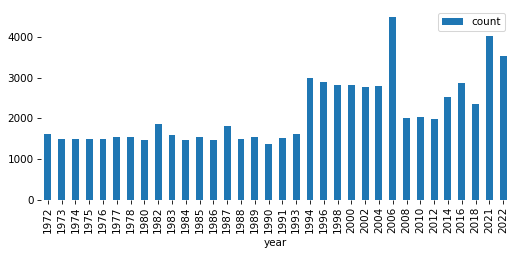

In [82]:
value_counts(gss['year']).plot(kind='bar')
decorate()

In [78]:
gss['age'].describe()

count    71636.000000
mean        44.985943
std         17.201666
min         18.000000
25%         30.000000
50%         43.000000
75%         58.000000
max         89.000000
Name: age, dtype: float64

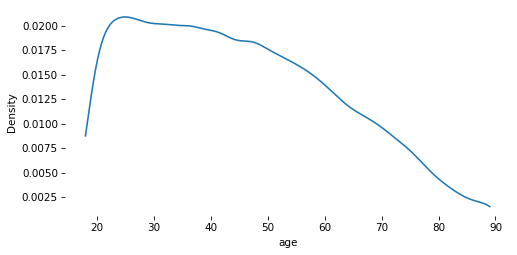

In [85]:
sns.kdeplot(gss['age'], cut=0)
decorate()

In [79]:
gss['cohort'].describe()

count    71635.000000
mean      1952.562853
std         21.977789
min       1883.000000
25%       1938.000000
50%       1954.000000
75%       1967.000000
max       2004.000000
Name: cohort, dtype: float64

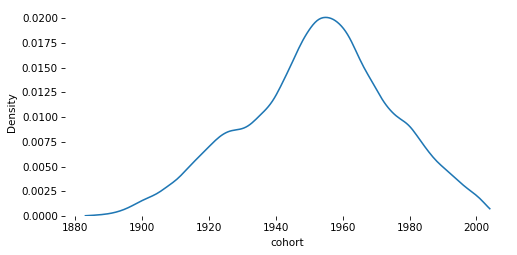

In [86]:
sns.kdeplot(gss['cohort'], cut=0)
decorate()

In [91]:
xtab = pd.crosstab(gss['cohort'], gss['age'])

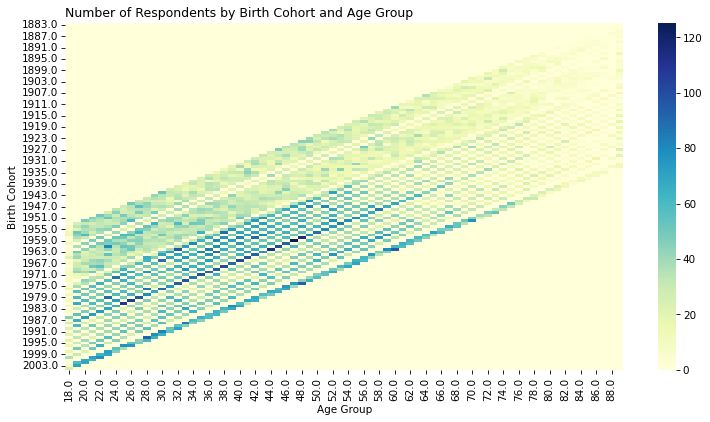

In [96]:
plt.figure(figsize=(12, 6))
sns.heatmap(
    xtab,
    cmap="YlGnBu",
)

plt.title("Number of Respondents by Birth Cohort and Age Group")
plt.xlabel("Age Group")
plt.ylabel("Birth Cohort")
plt.grid(False)

## Target variable

In [411]:
# https://gssdataexplorer.norc.org/variables/439/vshow

varname = 'helpful'

question = """Would you say that most of the time people try to be helpful,
or that they are mostly just looking out for themselves?
"""

responses = ['Helpful', 'Look out\nfor themselves', 'Depends']

ylabel = "Percent saying 'helpful'"

In [290]:
# https://gssdataexplorer.norc.org/variables/440/vshow

varname = 'fair'

question = """Do you think most people would try to take advantage of you 
if they got a chance, or would they try to be fair?
"""

responses = ['Take advantage', 'Fair', 'Depends']

ylabel = "Percent saying 'fair'"

In [291]:
# https://gssdataexplorer.norc.org/variables/441/vshow

varname = 'trust'

question = """Generally speaking, would you say that most people can be trusted
or that you can't be too careful in dealing with people?
"""

responses = ['Trusted', "Can't be\ntoo careful", 'Depends']

ylabel = "Percent saying 'trusted'"

In [352]:
# https://gssdataexplorer.norc.org/variables/434/vshow

varname = 'happy'

question = """Taken all together, how would you say things are these days--
would you say that you are very happy, pretty happy, or not too happy?
"""

responses = ['Very happy', "Happy", 'Not too happy']

ylabel = "Percent saying 'very happy'"

In [413]:
column = gss[varname]
column

0        2.0
1        1.0
2        2.0
3        2.0
4        2.0
        ... 
72385    2.0
72386    1.0
72387    NaN
72388    NaN
72389    1.0
Name: helpful, Length: 72390, dtype: float64

In [414]:
value_counts(column, dropna=False)

helpful
1.0    20471
2.0    18972
3.0     2971
NaN    29976
Name: count, dtype: int64

In [415]:
pmf = value_counts(column, normalize=True)
pmf

helpful
1.0    0.482647
2.0    0.447305
3.0    0.070048
Name: proportion, dtype: float64

In [416]:
from empiricaldist import Pmf

pmf = Pmf.from_seq(column)
pmf

,probs
helpful,
1.0,0.482647
2.0,0.447305
3.0,0.070048


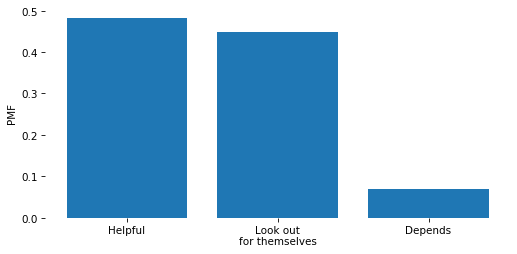

In [417]:
pmf.bar()
plt.xticks([1, 2, 3], responses)

decorate(ylabel='PMF')

## Time Series

In [418]:
gss72 = gss.query('year == 1972')
gss72.shape

(1613, 33)

In [419]:
pmf72 = Pmf.from_seq(gss72[varname])
pmf72

,probs
helpful,
1.0,0.467549
2.0,0.473220
3.0,0.059231


In [420]:
xtab = pd.crosstab(gss["year"], gss[varname], normalize='index')
xtab.head()

helpful,1.0,2.0,3.0
year,,,
1972,0.467549,0.473220,0.059231
1973,0.478581,0.492637,0.028782
1975,0.589588,0.354293,0.056119
1976,0.435278,0.499665,0.065057
1978,0.592252,0.353907,0.053841


In [421]:
time_series = xtab[1] * 100
time_series.name = "data"

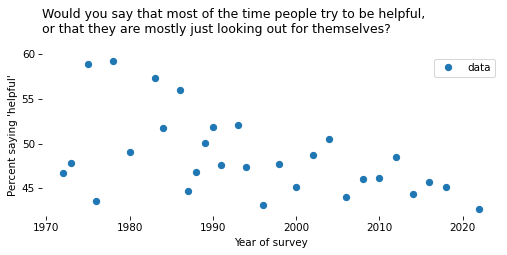

In [422]:
time_series.plot(style='o')
decorate(
    xlabel="Year of survey",
    ylabel=ylabel,
    title=question,
)

In [423]:
from statsmodels.nonparametric.smoothers_lowess import lowess


def make_lowess(series, frac=0.5):
    """Use LOWESS to compute a smooth line.

    series: pd.Series

    returns: pd.Series
    """
    y = series.to_numpy()
    x = series.index.to_numpy()

    smooth = lowess(y, x, frac)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index)

In [424]:
smooth = make_lowess(time_series)

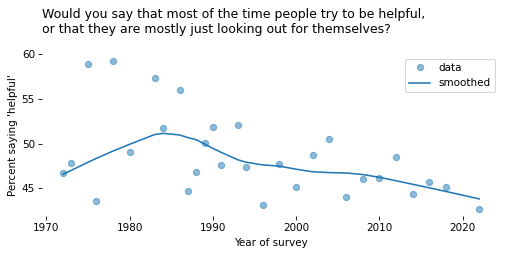

In [425]:
time_series.plot(style='o', alpha=0.5)
smooth.plot(label='smoothed', color='C0')

decorate(
    xlabel="Year of survey",
    ylabel=ylabel,
    title=question,
)

In [426]:
# tempting but wrong

gss['y'] = gss[varname] == 1
value_counts(gss['y'], dropna=False)

y
False    51919
True     20471
Name: count, dtype: int64

In [427]:
gss['y'] = np.where(gss['helpful'].notna(), gss['helpful'] == 1, np.nan)
value_counts(gss['y'], dropna=False)

y
0.0    21943
1.0    20471
NaN    29976
Name: count, dtype: int64

In [428]:
gss['y'] = gss[varname].replace([1, 2, 3], [1, 0, 0])
value_counts(gss['y'], dropna=False)

y
0.0    21943
1.0    20471
NaN    29976
Name: count, dtype: int64

## Pivot tables

In [429]:
polviews_map = {
    1: 'Liberal',
    2: 'Liberal',
    3: 'Liberal',
    4: 'Moderate',
    5: 'Conservative',
    6: 'Conservative',
    7: 'Conservative',
}

In [430]:
gss['polviews3'] = gss['polviews'].replace(polviews_map)

In [431]:
value_counts(gss['polviews3'], dropna=False)

polviews3
Conservative    21580
Liberal         17370
Moderate        23912
NaN              9528
Name: count, dtype: int64

In [432]:
table = gss.pivot_table(
    index='year', columns='polviews3', values='y', aggfunc='mean'
) * 100
table.head()

polviews3,Conservative,Liberal,Moderate
year,,,
1975,65.375854,60.476190,55.762082
1976,45.134576,42.339833,45.438596
1978,66.666667,54.245283,58.318739
1980,52.882704,44.848485,49.752066
1983,58.436214,53.191489,57.460317


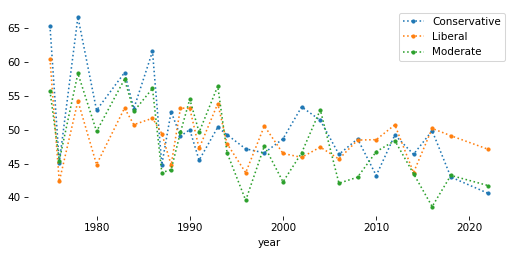

In [433]:
table.plot(style='.:')
decorate()

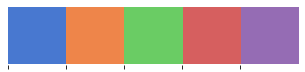

In [434]:
muted = sns.color_palette('muted', 5)
sns.palplot(muted)

In [435]:
color_map = {
    'Conservative': muted[3], 
    'Moderate': muted[4], 
    'Liberal': muted[0]
}

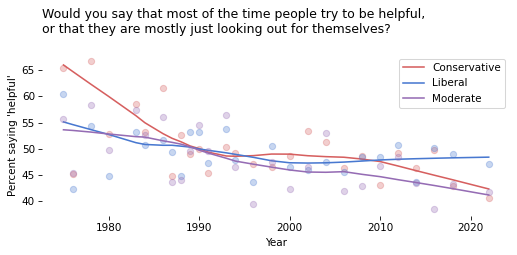

In [436]:
groups = ['Conservative', 'Liberal', 'Moderate']

for group in groups:
    series = table[group]
    color = color_map[group]
    series.plot(style='o', label='', color=color, alpha=0.3)
    smooth = make_lowess(series)
    smooth.plot(label=group, color=color)

decorate(
    xlabel='Year',
    ylabel=ylabel,
    title=question,
)

## Group by

Now that we have `y` as a binary variable, we have another way to compute the time series.

In [437]:
valid = gss.dropna(subset=['y'])

In [438]:
time_series2 = valid.groupby('year')['y'].mean() * 100
np.allclose(time_series, time_series2)

True

And the pivot table

In [439]:
table2 = valid.groupby(['year', 'polviews3'])['y'].mean().unstack() * 100
np.allclose(table, table2)

True

There are pros and cons of each method.

## Logistic regression

In [440]:
year_shift = gss['year'].median()
gss['x'] = gss['year'] - year_shift

In [441]:
valid_year = gss.dropna(subset=['y', 'x'])

In [442]:
import statsmodels.formula.api as smf

formula = 'y ~ x + I(x**2)'

model = smf.logit(formula, data=valid_year).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.691405
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                42414
Model:                          Logit   Df Residuals:                    42411
Method:                           MLE   Df Model:                            2
Date:                Mon, 28 Apr 2025   Pseudo R-squ.:                0.001646
Time:                        14:46:45   Log-Likelihood:                -29325.
converged:                       True   LL-Null:                       -29374.
Covariance Type:            nonrobust   LLR p-value:                 9.969e-22
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0823      0.014     -5.778      0.000      -0.110      -0.054
x             -0.0067      0.001     -9.587      0.000      -0.008      -0.005
I(x ** 2)  -3.607e-05   4.95e-05     -0.728      0.467      -0.000     6.1e-05
==============================================================================
"""

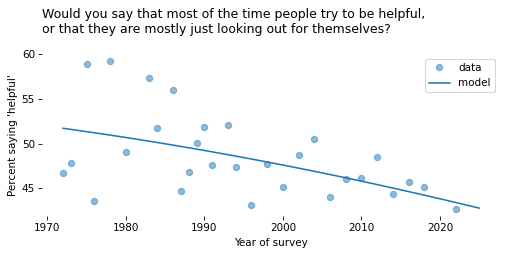

In [443]:
year_range = np.arange(1972, 2026)

pred_df = pd.DataFrame(dict(x=year_range - year_shift))

pred = model.predict(pred_df) * 100
pred.index = year_range

time_series.plot(style='o', alpha=0.5)
pred.plot(label='model', color='C0')

decorate(
    xlabel="Year of survey",
    ylabel=ylabel,
    title=question,
)

In [444]:
def fit_model(data, x_range, x_shift):
    formula = 'y ~ x + I(x**2)'
    model = smf.logit(formula, data=data).fit(disp=False)
    
    pred_df = pd.DataFrame(dict(x=x_range - x_shift))
    pred = model.predict(pred_df) * 100
    pred.index = x_range
    pred.name = 'model'

    return pred

In [445]:
pred2 = fit_model(valid_year, year_range, year_shift)
np.allclose(pred, pred2)

True

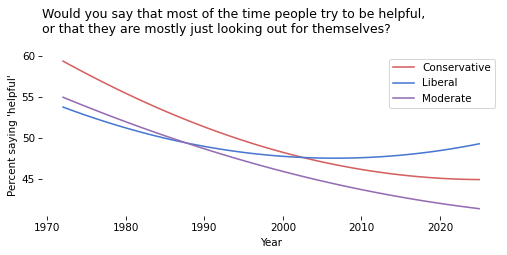

In [446]:
for name, group in valid_year.groupby('polviews3'):
    pred = fit_model(group, year_range, year_shift)
    pred.plot(label=name, color=color_map[name])
    
decorate(
    xlabel='Year',
    ylabel=ylabel,
    title=question,
)

## Group by year of birth

In [447]:
gss["cohort"] = gss["cohort"].replace(9999, np.nan)
gss["cohort"].describe()

count    71635.000000
mean      1952.562853
std         21.977789
min       1883.000000
25%       1938.000000
50%       1954.000000
75%       1967.000000
max       2004.000000
Name: cohort, dtype: float64

In [448]:
cohort_shift = gss['cohort'].median()

In [449]:
gss['x'] = gss['cohort'] - cohort_shift

In [450]:
valid_cohort = gss.dropna(subset=['y', 'x'])

In [451]:
series_cohort = valid_cohort.groupby('cohort')['y'].mean() * 100
series_cohort.name = 'data'

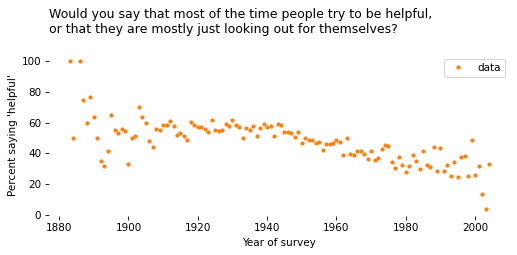

In [452]:
series_cohort.plot(style='.', color='C1')

decorate(
    xlabel="Year of survey",
    ylabel=ylabel,
    title=question,
)

In [453]:
cohort_range = np.arange(1880, 2010)

pred = fit_model(valid_cohort, cohort_range, cohort_shift)

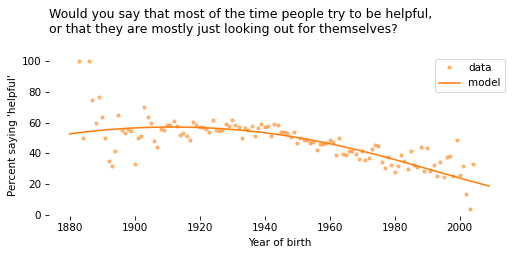

In [454]:
series_cohort.plot(style='.', color='C1', alpha=0.5)
pred.plot(color='C1')

decorate(
    xlabel="Year of birth",
    ylabel=ylabel,
    title=question,
)

## Just one cohort

In [455]:
gss['x'] = gss['year'] - year_shift

In [456]:
from utils import round_into_bins

gss["cohort10"] = round_into_bins(gss["cohort"], 10, 1880)
value_counts(gss["cohort10"])

cohort10
1880.0       45
1890.0      501
1900.0     1722
1910.0     3616
1920.0     5862
1930.0     7115
1940.0    10925
1950.0    14273
1960.0    11699
1970.0     7681
1980.0     5088
1990.0     2563
2000.0      545
2010.0      755
Name: count, dtype: int64

In [457]:
cohort_df = gss.query("cohort10 == 1940")
cohort_df.shape

(10925, 33)

In [458]:
series_cohort40 = cohort_df.groupby('year')['y'].mean() * 100
series_cohort40.name = '1940 cohort'

In [459]:
valid_cohort40 = cohort_df.dropna(subset=['y', 'x'])
valid_cohort40.shape

(6791, 33)

In [460]:
pred = fit_model(valid_cohort40, year_range, year_shift)

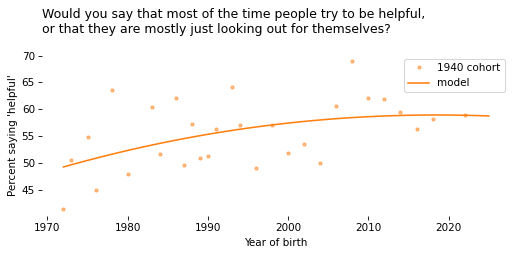

In [461]:
series_cohort40.plot(style='.', color='C1', alpha=0.5)
pred.plot(color='C1')

decorate(
    xlabel="Year of birth",
    ylabel=ylabel,
    title=question,
)

## All the Cohorts

In [462]:
def plot_cohort(df, cohort, color='C0'):
    cohort_df = df.query("cohort10 == @cohort")

    series_cohort = cohort_df.groupby('year')['y'].mean() * 100

    valid_cohort = cohort_df.dropna(subset=['y', 'x'])

    year = valid_cohort['year']
    year_range = np.arange(year.min(), year.max()+1)
    year_shift = year.median()

    pred = fit_model(valid_cohort, year_range, year_shift)
    x, y = pred.index[-1], pred.values[-1]
    plt.text(x, y, cohort, ha='left', va='center')

    pred.plot(label=cohort, color=color)

In [463]:
first, last = 1920, 1990
subset = gss.query("@first <= cohort <= @last" )
subset.shape

(62998, 33)

In [464]:
pred = fit_model(subset, year_range, year_shift)

In [465]:
cohorts = np.sort(subset['cohort10'].unique().astype(int))
cohorts

array([1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990])

In [466]:
cmap = plt.get_cmap('Purples')

colors = [cmap(x) for x in np.linspace(0.3, 0.9, len(cohorts))]

In [467]:
def anchor_legend(x, y):
    """Place the upper left corner of the legend box.

    x: x coordinate
    y: y coordinate
    """
    plt.legend(bbox_to_anchor=(x, y), loc="upper left")
    plt.tight_layout()

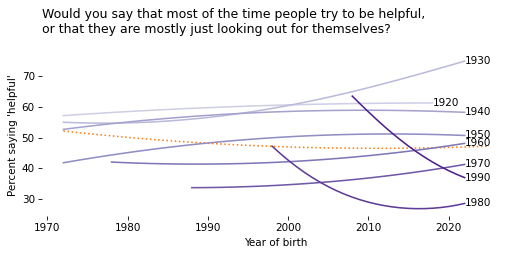

In [468]:
pred.plot(ls=':', color='C1')

for cohort, color in zip(cohorts, colors):
    plot_cohort(gss, cohort, color)
    
decorate(
    xlabel="Year of birth",
    ylabel=ylabel,
    title=question,
    legend=False
)

## Simpson's Paradox

Looking at birth cohorts, the composition of the population changes over time.
The following figure shows the distribution of birth years for the respondents at the beginning of the survey in 1973, near the middle in 1990, and most recently in 2018.

In [469]:
xtab_cohort = pd.crosstab(gss["cohort10"], gss["year"], normalize="columns")
xtab_cohort.head()

year,1972,1973,1974,1975,1976,1977,1978,1980,1982,1983,...,2004,2006,2008,2010,2012,2014,2016,2018,2021,2022
cohort10,,,,,,,,,,,,,,,,,,,,,
1880.0,0.003100,0.003989,0.008086,0.006711,0.004670,0.000000,0.003264,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1890.0,0.047737,0.038564,0.029650,0.036913,0.047365,0.027451,0.028721,0.017030,0.018817,0.005003,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1900.0,0.109733,0.099069,0.129380,0.081879,0.070047,0.090850,0.082898,0.059264,0.051075,0.038149,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1910.0,0.151891,0.158245,0.130728,0.130201,0.144096,0.124837,0.105091,0.123978,0.103226,0.093183,...,0.015647,0.007539,0.007909,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1920.0,0.223807,0.180186,0.192722,0.186577,0.158773,0.183660,0.152089,0.160082,0.148387,0.136961,...,0.038762,0.039911,0.038062,0.035225,0.025329,0.014184,0.009766,0.008518,0.0,0.0


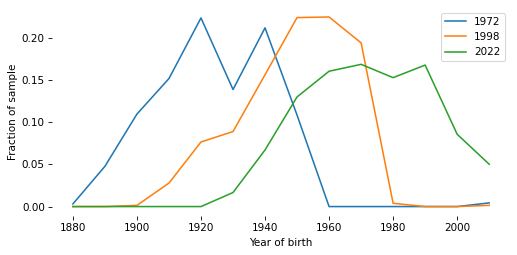

In [470]:
xtab_cohort[1972].plot(label="1972")
xtab_cohort[1998].plot(label="1998")
xtab_cohort[2022].plot(label="2022")

decorate(xlabel="Year of birth", ylabel="Fraction of sample")

Probably Overthinking It

Copyright 2022 Allen Downey 

The code in this notebook and `utils.py` is under the [MIT license](https://mit-license.org/).